## SageMaker - Data Preprocessing - Train, Test, Validation Split - Using Notebook

#### Import required packages.

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

In [3]:
region = sagemaker.Session().boto_region_name
role = sagemaker.get_execution_role()
print(region, "role")

us-east-2 role


**Create** a `SKLearnProcessor` object, passing the `scikit-learn` version we want to use, as well as our managed infrastructure requirements.

In [9]:
sklearn_processor = SKLearnProcessor(framework_version="0.23-1", role=role, instance_type="ml.t3.medium", instance_count=1)

#### Download Dataset

Read in the raw data from a public S3 bucket. 

In [6]:
import pandas as pd

# Download Files from S3
s3 = boto3.client("s3")
s3.download_file("sagemaker-sample-data-{}".format(region), "processing/census/census-income.csv", "census-income.csv",)

# Read files using Pandas
df = pd.read_csv("census-income.csv")

# Save a copy
df.to_csv("dataset.csv")

# Look at head
df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


#### Prepare Processing Script

In [7]:
%%writefile preprocessing.py

import pandas as pd
import os
from sklearn.model_selection import train_test_split

input_data_path = os.path.join("/opt/ml/processing/input", "dataset.csv")
df = pd.read_csv(input_data_path)
print("Shape of data is:", df.shape)

# Split Data for Train and Test
train, test = train_test_split(df, test_size=0.2)

# Split Data for Train and Validation
train, validation = train_test_split(train, test_size=0.2)

# Create Directories to Save Train, Test and Validation Dataset
try:
    os.makedirs("/opt/ml/processing/output/train")
    os.makedirs("/opt/ml/processing/output/validation")
    os.makedirs("/opt/ml/processing/output/test")
    
    print("Successfully created directories")
    
except Exception as e:
    print("Could not make directories: ", e)    
    
# Save rain, Test and Validation Dataset
try:
    train.to_csv("/opt/ml/processing/output/train/train.csv")
    validation.to_csv("/opt/ml/processing/output/validation/validation.csv")
    test.to_csv("/opt/ml/processing/output/test/test.csv")
    
    print("Files saved successfully")
    
except Exception as e:
    print("Failed to save files: ", e)

print("Completed running the processing job")

Writing preprocessing.py


#### Run Processing Job

Run the Processing job, specifying the script name, input file, and output files.

In [10]:
%%capture output

from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(
    code="preprocessing.py",
    # arguments = ["arg1", "arg2"], # Arguments can optionally be specified here
    inputs=[ProcessingInput(source="dataset.csv", destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output/train"),
        ProcessingOutput(source="/opt/ml/processing/output/validation"),
        ProcessingOutput(source="/opt/ml/processing/output/test"),
    ]
)

You can see the status of Preprocessing job in Sagemaker.

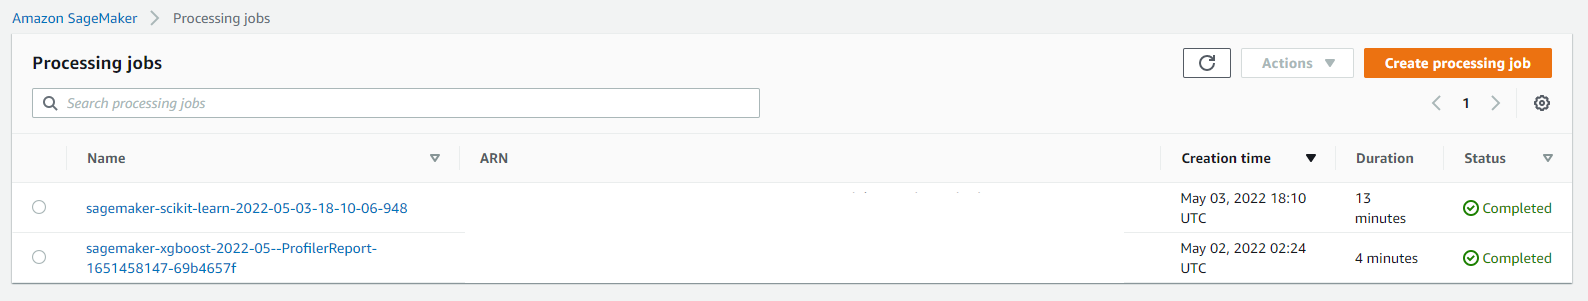

Get the Processing job logs and retrieve the job name.

In [11]:
print(output)
job_name = str(output).split("\n")[1].split(" ")[-1]


Job Name:  sagemaker-scikit-learn-2022-05-03-18-10-06-948
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-782329204437/sagemaker-scikit-learn-2022-05-03-18-10-06-948/input/input-1/dataset.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-782329204437/sagemaker-scikit-learn-2022-05-03-18-10-06-948/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-782329204437/sagemaker-scikit-learn-2022-05-03-18-10-06-948/output/output-1', 'LocalPath': '/opt/ml/processing/output/train', 

Confirm that the output dataset files were written to S3.

In [12]:
import boto3

s3_client = boto3.client("s3")
default_bucket = sagemaker.Session().default_bucket()

for i in range(1, 4):
    prefix = s3_client.list_objects(Bucket=default_bucket, Prefix=job_name + "/output/output-" + str(i) + "/")["Contents"][0]["Key"]
    print("s3://" + default_bucket + "/" + prefix)

s3://sagemaker-us-east-2-782329204437/sagemaker-scikit-learn-2022-05-03-18-10-06-948/output/output-1/train.csv
s3://sagemaker-us-east-2-782329204437/sagemaker-scikit-learn-2022-05-03-18-10-06-948/output/output-2/validation.csv
s3://sagemaker-us-east-2-782329204437/sagemaker-scikit-learn-2022-05-03-18-10-06-948/output/output-3/test.csv


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


You can also see these files in your S3 Bucket in AWS

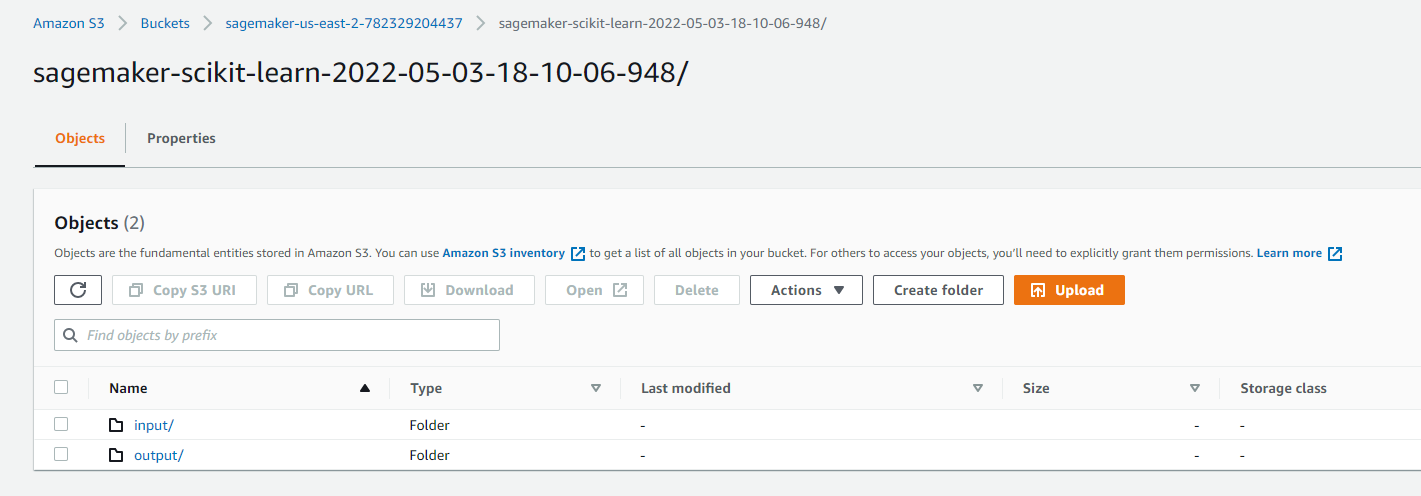